<h1> Local Blackbox Explanation Methods</h1>

<h2>Learning Objectives:</h2>

- Gain experience in implementing and using local Blackbox algorithm explanation techniques.
 - specifically RisE 
- To investigate gaining local insights into Blackbox decision making algorithms.
 - specifically object labeling from images 
- To critically appraise this technique in its use and limitations in explaining blackbox algorithms.

<h3>Local Explanations</h3>

Focus on example outcome explanation method as described in [1].

- RisE - Randomized Input Sampling for Explanation [2].

    
[1] R. Guidotti, A. Monreale, S. Ruggieri, F. Turini, D. Pedreschi, and F. Giannotti, “A Survey Of Methods For Explaining Black Box Models,” ACM Comput. Surv., Feb. 2018. https://dl.acm.org/doi/10.1145/3236009

[2] V. Petsiuk, A. Das, and K. Saenko, “RisE: Randomized input sampling for explanation of black-box models,” Br. Mach. Vis. Conf. 2018, BMVC 2018, vol. 1, 2019.https://arxiv.org/abs/1806.07421

In [1]:
import sys
import os
import tensorflow as tf
from platform import python_version 


#------------- Load in some helpful packages we will use for the lab -------------------------

import matplotlib.pyplot as plt
from skimage.transform import resize   #ERROR HERE COMMENT OUT
%matplotlib inline

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np # linear algebra


#------------- Print versions an paths for potencial debugging -------------------------

print('Python version:', python_version()) # print the version of python the script is using
print('Python path:', sys.executable) # print the path for the python executable the script is using
print('Working Directory:', os.getcwd()) # print the current working directory 
print ("TensorFlow version: " + tf.__version__) # print the tensorflow version



Python version: 3.11.5
Python path: c:\Users\hgnis\anaconda3\python.exe
Working Directory: d:\ProgrammingSpaceMain\abuses-biases-in-dataTEMP\Local Black Box Explanations Lab
TensorFlow version: 2.15.0


<h1> 1. Object Classification in Images</h1>

Treating the models as a Blackbox, using a pre-existing image object labeling model called ResNet50, this is a pre-trained model based on a CNNs architecture presented by He <i>et al</i> in [3]. Specifically this is a 50 layer residual net and has a total of 23,521 parameters.

[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep residual learning for image recognition,” Proc. IEEE Comput. Soc. Conf. Comput. Vis. Pattern Recognit., vol. 2016-December, pp. 770–778, 2016. https://arxiv.org/abs/1512.03385

  
<h2> 1.1 Load the Pre-Trained Blackbox Model an Image Object Classifier, $f$.</h2>


In [2]:
# Step 1: set height and width of images
IMG_HEIGHT = 224  # H
IMG_WIDTH = 224   # W

# Step 2: load ResNet50 Model
#f_restnet = ResNet50(weights='imagenet')

f_restnet = ResNet50(weights='imagenet')

f_restnet.summary() # prints the model architecture to the screen



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                     

## 1.2 Load an Image, $I$, for Inference

In [3]:
### START CODE HERE ###

#1: save file name and path
filename = 'images/Cat_Dog.jpg'

#2. load an image in PIL format
original_image = image.load_img(filename, target_size=(IMG_HEIGHT, IMG_WIDTH)) # load image from file

### END CODE ###

#re-size image to fit into model - PIL format
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)

# convert the PIL image (width, height) to a NumPy array (height, width, channel)
numpy_image = image.img_to_array(resize_image) 

# Convert the image array into 4D Tensor (samples, height, width, channels) by adding an extra dimension to the axis 0.
input_image_tensor = np.expand_dims(numpy_image, axis=0)

# create proccesed copy of the input image for resnet50
processed_image = preprocess_input(input_image_tensor.copy())     #######   NOTE TO SELF WHY IS THIS USED???


### START CODE HERE ###

#3. Print the size/shape of the image data at each stage of the pre-processing
print("Original image size and shape = ", original_image.size)
print("Resized image size and shape = ", resize_image.size)
print("NumPy image size and shape = ", numpy_image.size, numpy_image.shape)
print("Input tensor size and shape = ", input_image_tensor.size, input_image_tensor.shape)
print("Processed Input tensor size and shape = ", processed_image.size, processed_image.shape)

### END CODE ###

Original image size and shape =  (224, 224)
Resized image size and shape =  (224, 224)
NumPy image size and shape =  150528 (224, 224, 3)
Input tensor size and shape =  150528 (1, 224, 224, 3)
Processed Input tensor size and shape =  150528 (1, 224, 224, 3)


The image PIL is in the format of $height$ x $width$, the NumPy array is in the format $height$ x $width$ x $channels$ and the final image is in the format $number\_images$ x $height$ x $width$ x $channels$. Finally the 4D tensor is pre-processed (saved in more compresse format) and saved in `processed_image` to be passed into the model, $f$, for classification.


<h2>1.3 Display the Processed Input Image, $I$</h2>

Moving forward in the note book we will use two image input varibles, both variable are 4D tensors:
- The first `processed_image` will be passed to the model for classifcation
- the second `input_image_tensor` is essentially exactly the same data as in `processed_image` only saved in a differnet format (on disk) we use this variable if we want to see or visulaise the data.


input_image_tensor[0] shape (224, 224, 3)


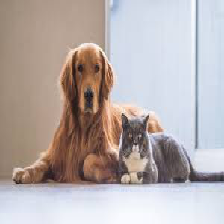

In [4]:

#1. print the shape of the first image data in the array.
print('input_image_tensor[0] shape', input_image_tensor[0].shape) 


#2. visualize a sample image 
image.array_to_img(input_image_tensor[0])  # display the image


## 1.4 Classify the Image, $I$, with the model, $f$.

ResNet50 model it returns the classification score for all 1,000 labels at the same time for an image it is classifying.

In [5]:
#1: predict ojects in image using resenet
predictions_resnet50 = f_restnet.predict(processed_image)

#2: investigate top 10 and top 20 lables
label_resnet50 = decode_predictions(predictions_resnet50, top=10) # top 10 labels

print ("label_resnet50 = ", label_resnet50)

1/1 [==============================] - 4s 4s/step
label_resnet50 =  [[('n02100877', 'Irish_setter', 0.47670102), ('n02099601', 'golden_retriever', 0.32893014), ('n02088094', 'Afghan_hound', 0.074805774), ('n02102318', 'cocker_spaniel', 0.05734294), ('n02091831', 'Saluki', 0.044173643), ('n02102480', 'Sussex_spaniel', 0.0041603306), ('n02100735', 'English_setter', 0.0022135465), ('n02101006', 'Gordon_setter', 0.0021527044), ('n02099267', 'flat-coated_retriever', 0.0017337763), ('n02088466', 'bloodhound', 0.001030885)]]


<h1>3. Explaining Model Classifications using Randomized Input Sampling for Explanation (RisE)</h1>


Explore a method applied to image classification explanation introduced by Petsiuk <i>et al</i> in [2]  Specifically an approach called RisE (Randomized Input Sampling for Explanation) that generates a salience map indicating the <b>importance</b> of each pixel's contribution to the model’s prediction.

This is achieved by once again treating the model as a black box and only using the inference process. This is done by generating randomly varied masks, combined with the image to generate a salience map.

[2] V. Petsiuk, A. Das, and K. Saenko, “RisE: Randomized input sampling for explanation of black-box models,” Br. Mach. Vis. Conf. 2018, BMVC 2018, vol. 1, 2019.https://arxiv.org/abs/1806.07421

## 2.1 Mask Generation, $M_i$.


<b>Taken from the paper:</b>

1. Create $N$ binary masks of size $h×w$ (smaller than image size $H × W$) by setting each element independently to 1 with probability $pl$ and to 0 with the remaining probability.

2. Up-sample all masks to size $(h+1)CH \times (w+1)CW$ using bilinear interpolation, where $CH \times CW = \frac{H}{h} \times \frac{W}{w}$ is the size of the cell in the up-sampled mask.

3. Crop areas $H \times W$ with uniformly random indents from (0,0) up to (CH,CW).

<b>End of paper quote</b>

Where above: $h$ and $w$ refer to height and width of masked grid;  $H$ and $W$ refer to height and width of input image; $CH$ and $CW$ refer to height and width of cell-size meaning the number pixels in the input image that are covered by a single pixel in the grid mask. i.e.  $CH = \frac{H}{h}$ and  $CW = \frac{W}{w}$.

<h3>2.1.1 Generating Small Random Grids</h3>


In [6]:

#1: Set the varible for number of masks, size of grid and proabaility of grid pixel being 1
N = 1000 # set numer of binary masks
s = 8   # set the size of the mask value for h & w 
pl = 0.5  # set probability of each element from in the mask being a one

#2. Create N grids of size s x s containing random 0's and 1's with equal proability.
grid = np.random.randint(low=0, high=2, size=(N, s, s))

#3. Print the shape of the 3D array generated.
print("Size of grid array: ", grid.shape)

unique, counts = np.unique(grid, return_counts=True)
p =  counts[1] / sum(counts)
print("probability of ones acieved = ",p)


Size of grid array:  (1000, 8, 8)
probability of ones acieved =  0.498390625


grid[0] shape (8, 8)


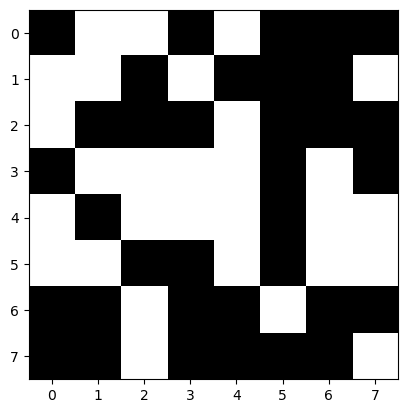

In [7]:
#1. print size of the first grid in the arrayof grids
print('grid[0] shape', grid[0].shape) 

# change the gird to be viewed to see if they are all random and different.
plt.gray()
plt.imshow((grid[2]), interpolation='nearest') # display the image


<h3>2.1.2 Change the Random Grids into Masks</h3>

Take the grids and use them to generate masks, $M_i$. The masks need to be the same size as the input image. 

<b>Note:</b> the code then up-sizes the grid to full input image resolution (with shifting to make the mask more random as described in steps 2 & 3 in the paper).

In [8]:
grid = grid.astype('float32')

#1: create array and print shape of array
M_i = np.zeros((N, IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)

#2. Print size of array
print("masks shape", M_i.shape)

# Calucate cell size
cell_size = np.ceil(np.array((IMG_HEIGHT,IMG_WIDTH)) / s)
up_size = (s + 1) * cell_size

for i in range(N):
    # Random shifts
    x = np.random.randint(0, cell_size[0])
    y = np.random.randint(0, cell_size[1])
    # Linear upsampling and cropping
    M_i[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=True)[x:x + IMG_HEIGHT, y:y + IMG_WIDTH]


masks shape (1000, 224, 224)


<h3> 2.1.3 View Generated Masks, $M_i$</h3>

Display examples of the the full size masks, $M_i$.


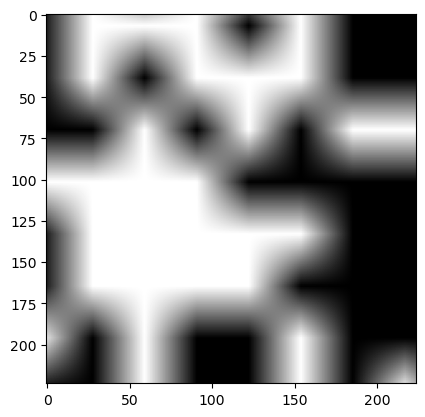

In [9]:
plt.gray()
plt.imshow((M_i[0]))


## 2.2 Combine Masks and Original Image, $I \odot M_i$

Create $N$ versions of the input image each one masked by one of the random masks, $M_i$.  Note since the input image , $I$ has three channles the code reshpaes the `M_i` array to contant the same number of dimentions as the 4D input_image_tensor.


Note: the shape of the masksd image array, $I \odot M_i$, should be $N \times H \times W \times ch$ i.e. 1000 x 224 x 224 x 3.

In [10]:
M_i = M_i.reshape(-1, IMG_HEIGHT,IMG_WIDTH, 1)

#1. Print shape of M_i
print("shape of  M_i ", M_i.shape)

#2: pixelwise multiplication the masks and the input image 
masked = input_image_tensor * M_i

#print shape of masked images
print("Masked Images", masked.shape)


shape of  M_i  (1000, 224, 224, 1)
Masked Images (1000, 224, 224, 3)



<h3>2.2.1 Investigate the Different Masked Images and Classification Labels</h3>

Run a given masked image through the classifier model, $f$, to get the score for a given class.

- Set $test\_image$ to one of the masked images. <b>Hint:</b> the index ranges from 0 to $N$ each referring to a different masked image.

```python masked[index]```

- Run the classifier, $f$. The code to classify and image below where $I$ is the image being classified i.e. $test\_image$.
```python f_restnet.predict(I)```

- Change the test image for different masked image and rerun the.
- Change the classification label using the number ID and run code.

Note: Use the look-up table provided here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a in order to find out the number ID for the label to investigate.

1/1 [==============================] - 0s 136ms/step
Classification confidence for class tiger_cat is:  [0.00044246]


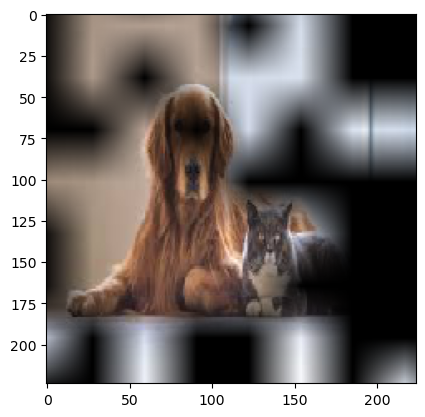

In [11]:
test_image = masked[0]

plt.imshow(np.uint8(test_image))
test_image = np.expand_dims(test_image, axis=0)

def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

pred_test_image = f_restnet.predict(test_image)

class_label = 282 # set the class label to 282

print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,class_label])



<h2>2.3 Run Classifier for All Masked Images</h2>
    

In [12]:
batch_size = 100

preds = []
# Make sure multiplication is being done for correct axes

for i in range(0, N, batch_size):
    preds.append(f_restnet.predict(masked[i:min(i+batch_size, N)]))
preds = np.concatenate(preds)


4/4 [==============================] - 8s 2s/step


In [13]:
preds.shape

(1000, 1000)

<h3>2.3.1 Calculate Salient Map using Weighted Average</h3>



<b>Note:</b> when the salience is displayed over the image a colour scheme (called jet) is used to illustrate the importance of each pixels contribution to the given Classification.


In [14]:
sal = preds.T.dot(M_i.reshape(N, -1)).reshape(-1, IMG_HEIGHT,IMG_WIDTH)
sal = sal / N / pl

<h3>2.3.2 Plot the Salience Map Over the Input Image</h3>

Human readable classification codes https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
    

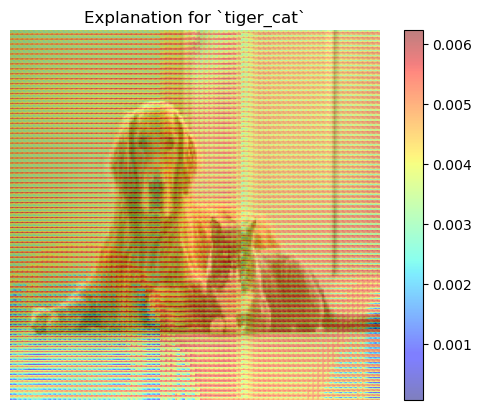

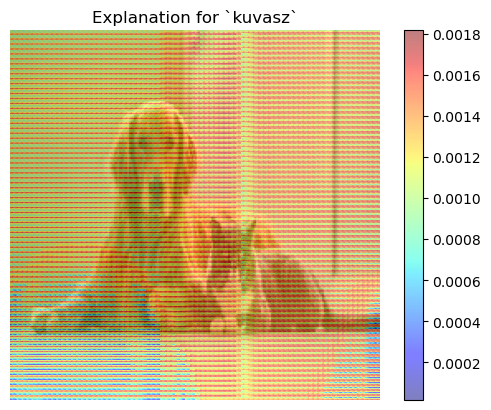

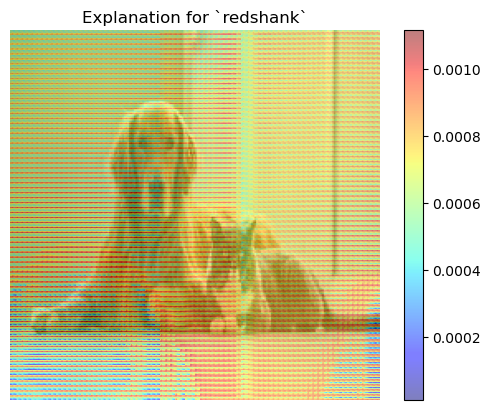

In [15]:
class_idx = 282

plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

# New label
class_idx = 222

plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

# New label
class_idx = 141

plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

<h1>3. Investigate Saliance maps for ten images</h1>

In [16]:
# Define a general function to investigate the image
def investigate(flname, class_num1, class_num2):

    original_image = image.load_img(flname)
    resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)

    numpy_image = image.img_to_array(resize_image) 

    input_image_tensor = np.expand_dims(numpy_image, axis=0)

    processed_image = preprocess_input(input_image_tensor.copy()) 
    predictions_resnet50 = f_restnet.predict(processed_image)

    label_resnet50 = decode_predictions(predictions_resnet50, top=10)
    
    print ("label_resnet50 = ", label_resnet50)

    N = 1000 # set numer of binary masks
    s = 8   # set the size of the mask value for h & w 
    pl = 0.5  # set probability of each element from in the mask being a one

    grid = np.random.randint(low=0, high=2, size=(N, s, s))

    print("Size of grid array: ",grid.shape)

    unique, counts = np.unique(grid, return_counts=True)
    p =  counts[1] / sum(counts)
    print("probability of ones achieved =", p)

    print(grid[0].shape) 

    plt.gray()
    plt.imshow((grid[3]))
    plt.show()

    grid = grid.astype('float32')

    M_i = np.empty(shape=(N, IMG_HEIGHT, IMG_WIDTH))

    print("masks shape", M_i.shape)

    cell_size = np.ceil(np.array((IMG_HEIGHT,IMG_WIDTH)) / s)
    up_size = (s + 1) * cell_size

    for i in range(N):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        M_i[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=True)[x:x + IMG_HEIGHT, y:y + IMG_WIDTH]

    plt.gray()
    plt.imshow((M_i[0]))
    plt.show()

    M_i = M_i.reshape(-1, IMG_HEIGHT,IMG_WIDTH, 1)

    print("shape of  M_i ", M_i.shape)

    masked = M_i * input_image_tensor

    print("Masked Images", masked.shape)

    test_image = masked[0]

    plt.imshow(np.uint8(test_image))
    test_image = np.expand_dims(test_image, axis=0)

    def class_name(idx):
        return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

    pred_test_image = f_restnet.predict(test_image)
    plt.show()

    class_label = class_num1

    print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,class_label])

    batch_size = 100

    preds = []

    for i in range(0, N, batch_size):
        preds.append(f_restnet.predict(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)

    preds.shape

    sal = preds.T.dot(M_i.reshape(N, -1)).reshape(-1, IMG_HEIGHT,IMG_WIDTH)
    sal = sal / N / pl


    class_idx = class_num1

    plt.title('Explanation for `{}`'.format(class_name(class_idx)))
    plt.axis('off')
    plt.imshow(np.uint8(input_image_tensor[0]))
    plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.show()

    class_idx = class_num2

    plt.title('Explanation for `{}`'.format(class_name(class_idx)))
    plt.axis('off')
    plt.imshow(np.uint8(input_image_tensor[0]))
    plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.show()

1/1 [==============================] - 23s 23s/step
label_resnet50 =  [[('n02129165', 'lion', 0.905914), ('n02412080', 'ram', 0.037969794), ('n02134084', 'ice_bear', 0.029954791), ('n02132136', 'brown_bear', 0.010243259), ('n02112137', 'chow', 0.004450829), ('n02114548', 'white_wolf', 0.0017561441), ('n02111889', 'Samoyed', 0.000855465), ('n02437616', 'llama', 0.00058958534), ('n02109961', 'Eskimo_dog', 0.00054292224), ('n02129604', 'tiger', 0.00050628703)]]
Size of grid array:  (1000, 8, 8)
probability of ones achieved = 0.49790625
(8, 8)


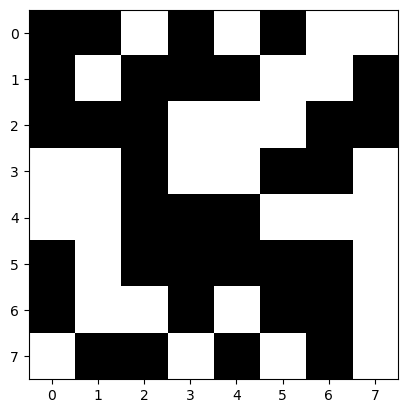

masks shape (1000, 224, 224)


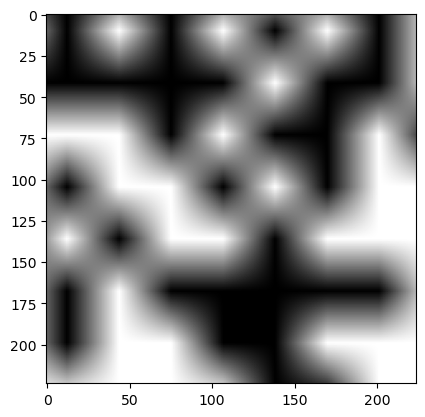

shape of  M_i  (1000, 224, 224, 1)
Masked Images (1000, 224, 224, 3)
1/1 [==============================] - 8s 8s/step


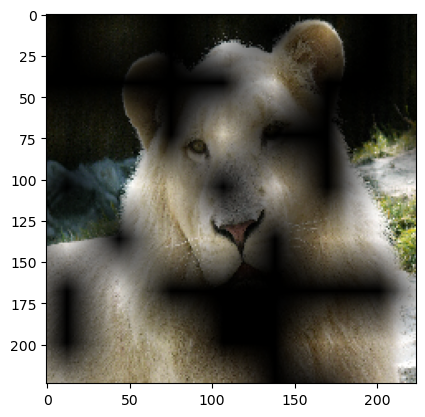

Classification confidence for class lion is:  [0.00010375]
4/4 [==============================] - 8s 2s/step


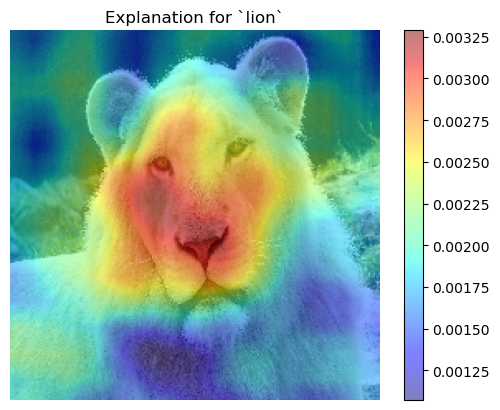

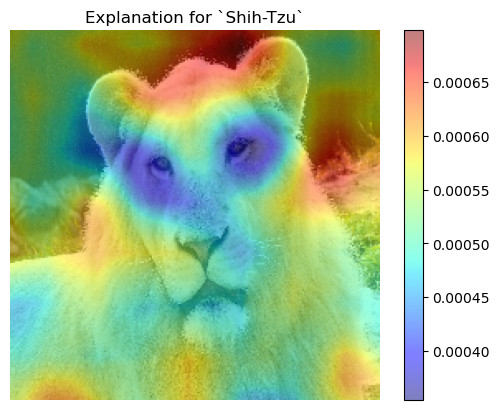

In [17]:
investigate('images/lion.jpg', 291, 155)

1/1 [==============================] - 17s 17s/step
label_resnet50 =  [[('n02504013', 'Indian_elephant', 0.4209665), ('n01871265', 'tusker', 0.36919987), ('n02504458', 'African_elephant', 0.1688453), ('n02412080', 'ram', 0.0025451053), ('n01695060', 'Komodo_dragon', 0.0014737786), ('n01688243', 'frilled_lizard', 0.0013639138), ('n02397096', 'warthog', 0.0013497584), ('n02113799', 'standard_poodle', 0.0013233633), ('n02963159', 'cardigan', 0.0012934722), ('n03000247', 'chain_mail', 0.0011402244)]]
Size of grid array:  (1000, 8, 8)
probability of ones achieved = 0.500625
(8, 8)


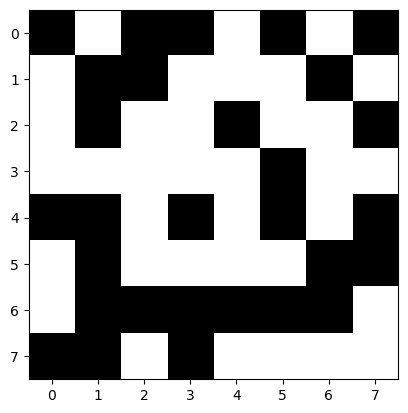

masks shape (1000, 224, 224)


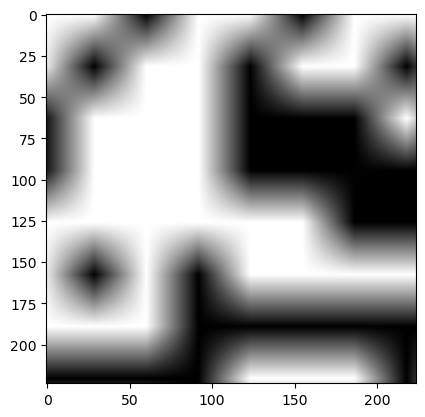

shape of  M_i  (1000, 224, 224, 1)
Masked Images (1000, 224, 224, 3)
1/1 [==============================] - 1s 515ms/step


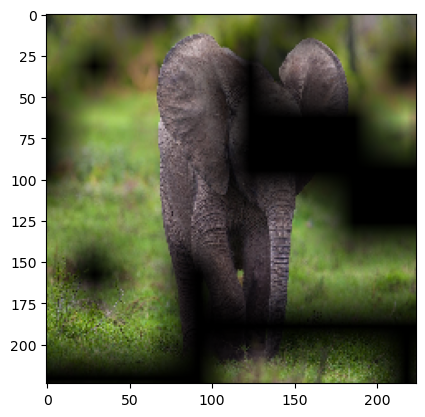

Classification confidence for class African_elephant is:  [1.1456592e-05]
4/4 [==============================] - 9s 2s/step


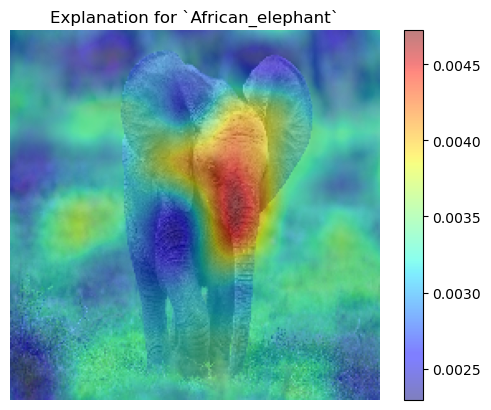

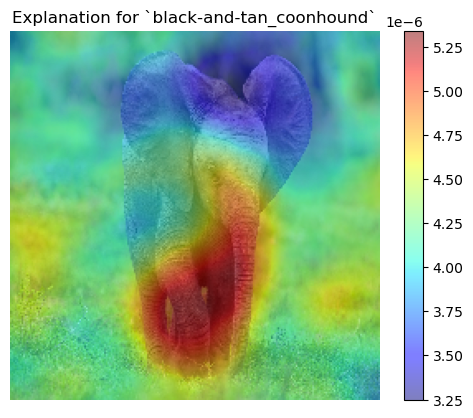

In [18]:
investigate('images/elephant.jpg', 386, 165)

1/1 [==============================] - 58s 58s/step
label_resnet50 =  [[('n01828970', 'bee_eater', 0.7833102), ('n01843383', 'toucan', 0.16823578), ('n01820546', 'lorikeet', 0.0047427863), ('n01818515', 'macaw', 0.0038747573), ('n01531178', 'goldfinch', 0.0037515573), ('n01560419', 'bulbul', 0.0035483816), ('n01797886', 'ruffed_grouse', 0.0032637313), ('n01580077', 'jay', 0.0026046121), ('n02056570', 'king_penguin', 0.0017477677), ('n01807496', 'partridge', 0.001579268)]]
Size of grid array:  (1000, 8, 8)
probability of ones achieved = 0.5015625
(8, 8)


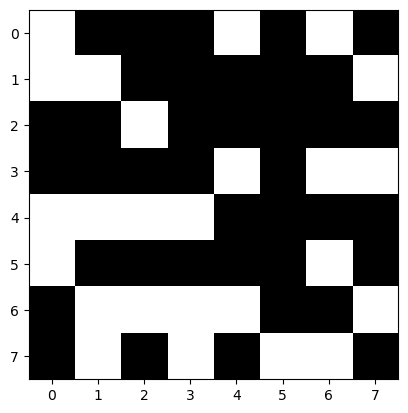

masks shape (1000, 224, 224)


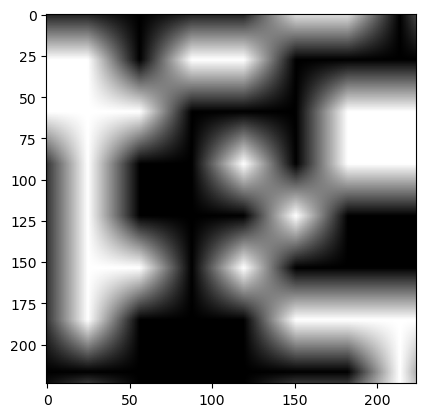

shape of  M_i  (1000, 224, 224, 1)
Masked Images (1000, 224, 224, 3)
1/1 [==============================] - 0s 223ms/step


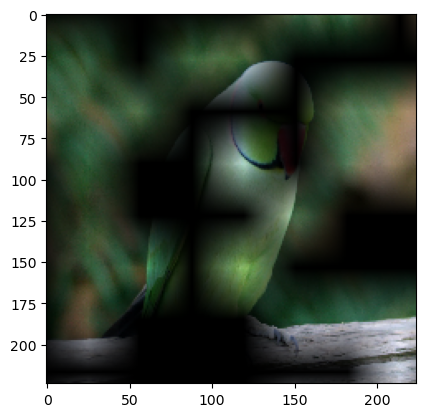

Classification confidence for class sulphur-crested_cockatoo is:  [2.2182498e-05]
4/4 [==============================] - 8s 2s/step


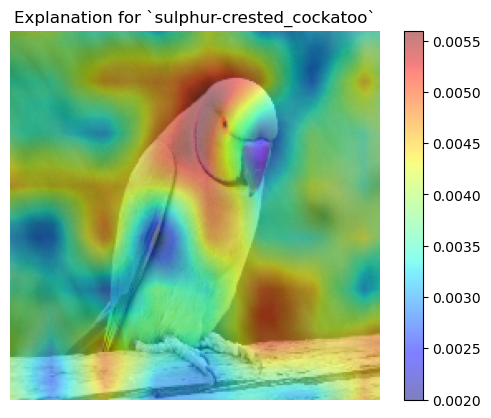

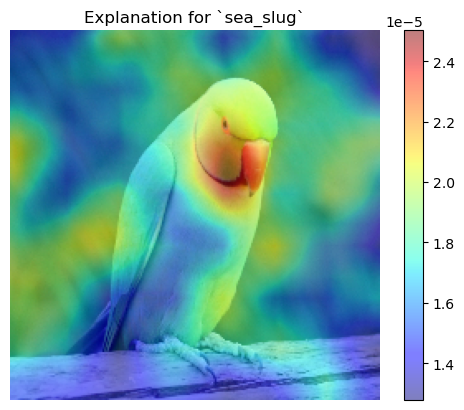

In [19]:
investigate('images/parrot.jpg', 89, 115)

1/1 [==============================] - 1s 1s/step
label_resnet50 =  [[('n01855672', 'goose', 0.94331175), ('n01847000', 'drake', 0.027727403), ('n02018207', 'American_coot', 0.008851677), ('n01860187', 'black_swan', 0.007613519), ('n02006656', 'spoonbill', 0.00521878), ('n02007558', 'flamingo', 0.0014592827), ('n02051845', 'pelican', 0.00103423), ('n02009912', 'American_egret', 0.0010017258), ('n01855032', 'red-breasted_merganser', 0.000943), ('n09332890', 'lakeside', 0.0003858047)]]
Size of grid array:  (1000, 8, 8)
probability of ones achieved = 0.49890625
(8, 8)


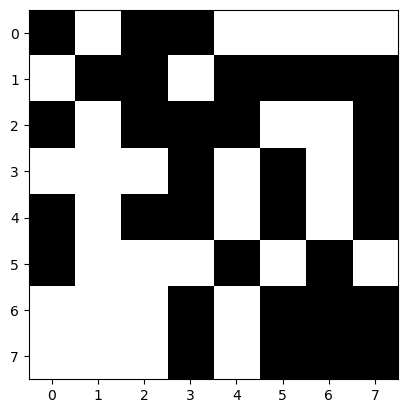

masks shape (1000, 224, 224)


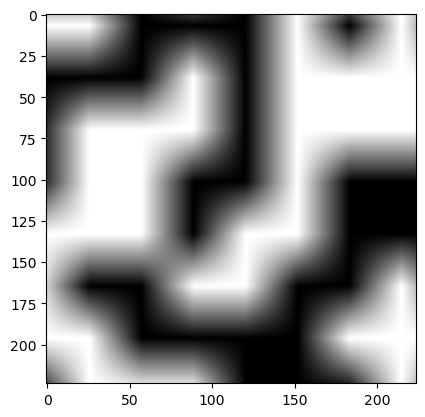

shape of  M_i  (1000, 224, 224, 1)
Masked Images (1000, 224, 224, 3)
1/1 [==============================] - 2s 2s/step


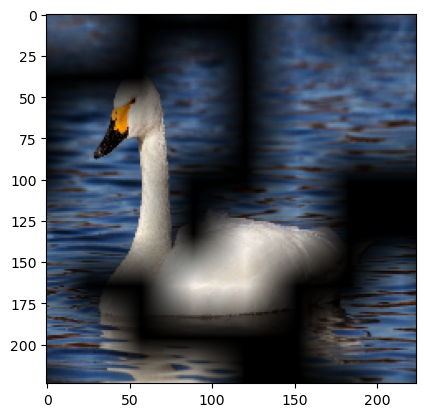

Classification confidence for class water_ouzel is:  [3.3656975e-06]
4/4 [==============================] - 10s 2s/step


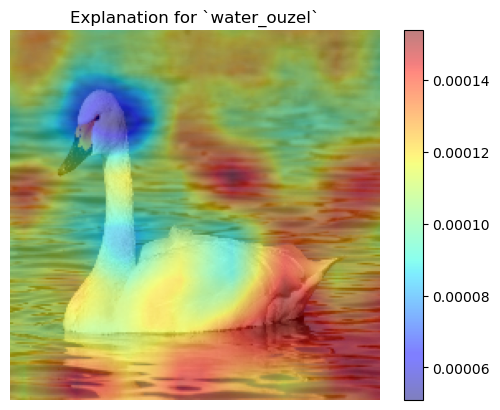

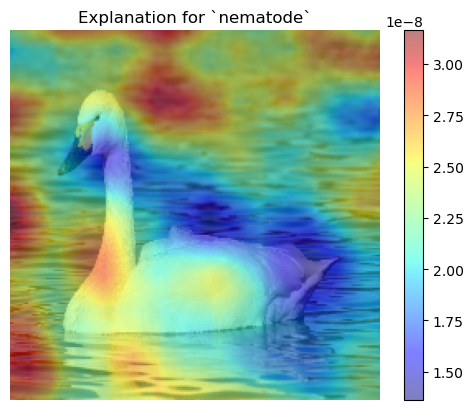

In [20]:
investigate('images/swan.jpg', 20, 111)

1/1 [==============================] - 1s 1s/step
label_resnet50 =  [[('n02391049', 'zebra', 0.9919099), ('n01518878', 'ostrich', 0.0012690104), ('n04604644', 'worm_fence', 0.00078308524), ('n02423022', 'gazelle', 0.00037068376), ('n01798484', 'prairie_chicken', 0.00023065212), ('n02110341', 'dalmatian', 0.00015287264), ('n02123159', 'tiger_cat', 0.00012469679), ('n02422106', 'hartebeest', 0.000111017456), ('n02129604', 'tiger', 0.00010531671), ('n02130308', 'cheetah', 0.000104867904)]]
Size of grid array:  (1000, 8, 8)
probability of ones achieved = 0.503125
(8, 8)


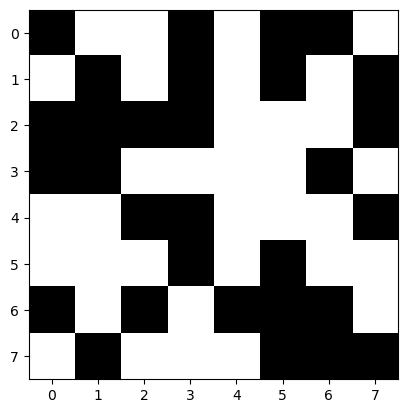

masks shape (1000, 224, 224)


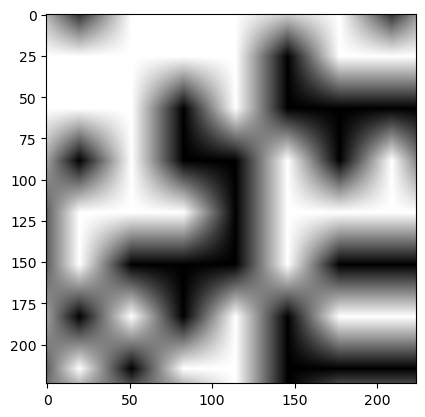

shape of  M_i  (1000, 224, 224, 1)
Masked Images (1000, 224, 224, 3)
1/1 [==============================] - 0s 311ms/step


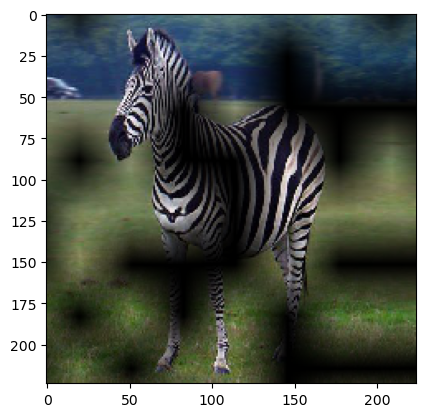

Classification confidence for class zebra is:  [0.99947435]
4/4 [==============================] - 9s 2s/step


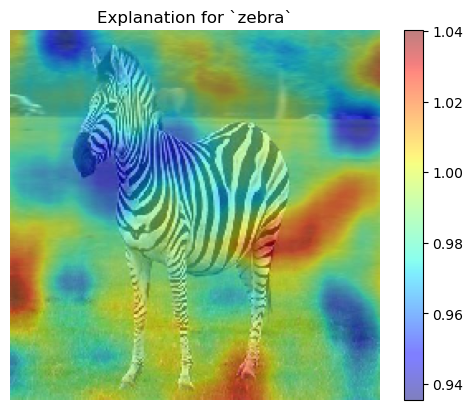

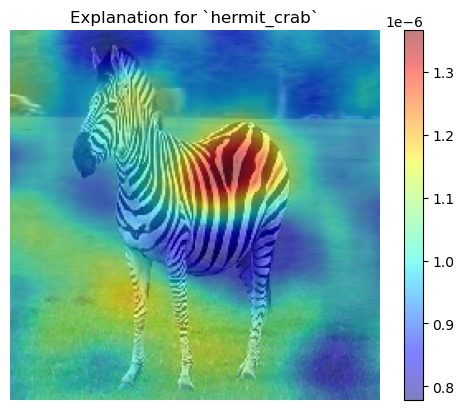

In [21]:
investigate('images/zebra.jpg', 340, 125)

<h1>4. Critical Analysis, Reflection & Discussion</h1>

- Why does the RisE method start with small grid of 8 x 8 and not simply generate randomized masks at full size?
> To efficiently explore diverse image variations before scaling up, allowing for better convergence and more effective generation of randomized masks at larger sizes. Stepwise approach balances computational efficiency and effective mask generation.
- Does sailence relate to absolute classification confidence?
> Salience highlights the relevance of features, helping to understand which aspects contribute more to the model's decision, but it doesn't directly indicate the confidence level of that decision.
- How does the RisE method fair in the following criteria for model explanations:
    - Interpretability
    > The process of creating masks helps highlight regions of importance, contributing to the interpretability of the model's decision.
    - Accuracy
    > The accuracy of RisE depends on the model it is applied to. While it can offer valuable insights into feature importance, its accuracy is contingent on the effectiveness of the underlying model and average of the masks.
    - Fidelity
    > It strives to maintain fidelity by preserving the relationship between features and model predictions.
- Overall (Model and explaintion) how does each system fair in terms of:
    - Reliability / Robustness: Maintain performance levels independently from parameters or input data
    > Model picks up on quirky details that may cause it to classify well but hurt reliability of the explanation.
    - Causality: controlled change in the input data affect the model behavior  
    > Focus on understanding feature importance rather than establishing causal relationships.
    - Generality: portable models that can work in multiple contexts
    > Robust as models can classify with highly noisy images and can still be expected to perform well.
    

     
